In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
import itertools as it
import networkx as nx
import random
import operator
import warnings
warnings.filterwarnings('ignore')

1)

In [28]:
def analizar_grafo(grafo):

    
    print("Cantidad de nodos: {0}".format(grafo.number_of_nodes()))
    print("Cantidad de aristas: {0}".format(grafo.number_of_edges()))
    
    """
    print("Cantidad de componentes conexas: ", len(componentes_conexas))
    print("Cantidad de nodos de la componente conexa gigante: ", tupla_componente_gigante[1])
    
    G = grafo.subgraph(tupla_componente_gigante[0])
    
    print("Segunda Componente :")
    segunda = grafo.copy()
    segunda.remove_nodes_from(G)
    if segunda.number_of_nodes() > 0 :
        componentes_conexas = [x for x in nx.connected_components(segunda)]
        tupla_componente_gigante = max([(x, len(x)) for x in componentes_conexas], key=lambda x:x[1])

        print("Cantidad de nodos: {0}".format(segunda.number_of_nodes()))
        print("Cantidad de aristas: {0}".format(segunda.number_of_edges()))
        print("Cantidad de componentes conexas: ", len(componentes_conexas))
        print("Cantidad de nodos de la componente conexa gigante: ", tupla_componente_gigante[1])
    
    return G
    """

In [27]:
def calcular_componentes_conexas_ordenadas(grafo):
    componentes_conexas = [x for x in nx.connected_components(grafo)]
    return sorted([(x, len(x)) for x in componentes_conexas], key=lambda x:x[1], reverse=True)

def calcular_componente_conexa_gigante(grafo):
    return grafo.subgraph((calcular_componentes_conexas_ordenadas(grafo)[0])[0])

In [4]:
G = nx.Graph()

with open('./data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        autores = [autor.strip() for autor in row[3].split('&')]
        coautorias = it.combinations(autores, 2)
        G.add_edges_from(coautorias)


In [5]:
analizar_grafo(G)

Cantidad de nodos: 3698
Cantidad de aristas: 7880


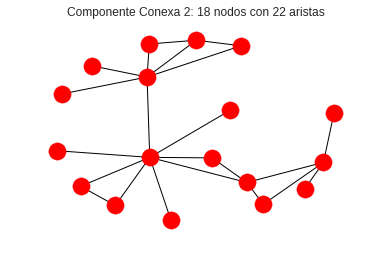

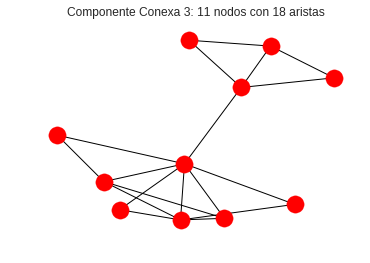

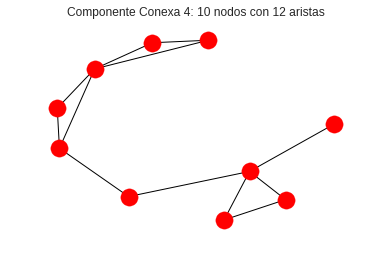

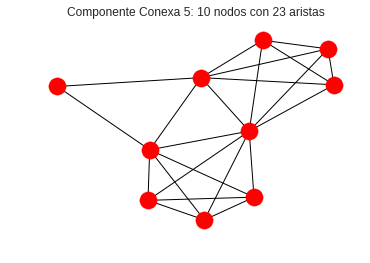

In [44]:
# Elegimos plotear desde la segunda componente conexa hasta la n
n = 5
componentes_conexas_ordenadas = calcular_componentes_conexas_ordenadas(G)
for i in range(1,n):
    grafo = G.subgraph(componentes_conexas_ordenadas[i][0])
    plt.figure()
    plt.title("Componente Conexa {0}: {1} nodos con {2} aristas".format(i+1, grafo.number_of_nodes(), grafo.number_of_edges()))
    nx.draw(grafo)

2)

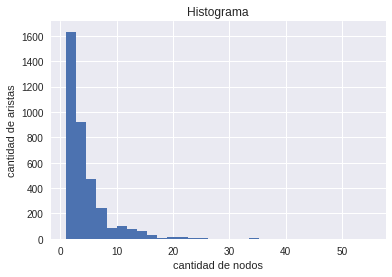

In [48]:
grados = list(nx.degree(G).values())
dist, bins, patches = plt.hist(grados, bins=30)
plt.title("Histograma")
plt.xlabel("cantidad de nodos")
plt.ylabel("cantidad de aristas")
plt.show()


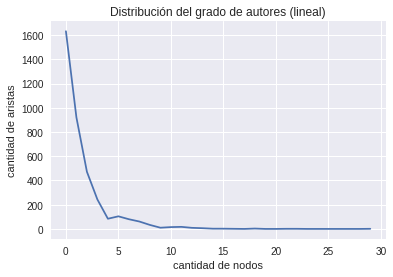

In [55]:
plt.title("Distribución del grado de autores (lineal)")
plt.xlabel("cantidad de nodos")
plt.ylabel("cantidad de aristas")
plt.plot(dist)

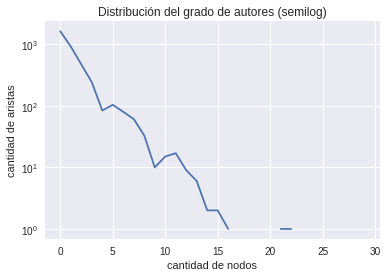

In [54]:
plt.title("Distribución del grado de autores (semilog)")
plt.xlabel("cantidad de nodos")
plt.ylabel("cantidad de aristas")
plt.semilogy(dist)

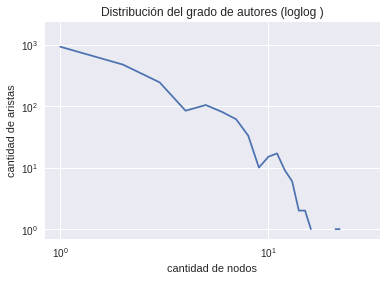

In [53]:
plt.title("Distribución del grado de autores (loglog )")
plt.xlabel("cantidad de nodos")
plt.ylabel("cantidad de aristas")
plt.loglog(dist)

Podemos observar que al graficar la distribución en escala semilog obtenemos un gráfico que se asemeja mucho más a uno lineal que al graficarla con la escala loglog, por lo tanto pareciera ser que se trata de una distribución exponencial.

3)

In [59]:
componente_conexa_gigante = G.subgraph(componentes_conexas_ordenadas[0][0])

print("cantidad de componentes conexas: ", len(componentes_conexas_ordenadas))
analizar_grafo(componente_conexa_gigante)

cantidad de componentes conexas:  236
Cantidad de nodos: 3018
Cantidad de aristas: 7269


4)

In [61]:
def invert_map(map):
    inv_map = {}
    for k, v in map.items():
        inv_map.setdefault(v, [])
        inv_map[v].append(k)
    return inv_map

def authors_by_distance(componente_gigante):
    nodo_raiz_idx = random.randint(0, len(componente_gigante) - 1)
    nodo_raiz = componente_gigante.nodes()[nodo_raiz_idx]

    paths = invert_map(all_distances[nodo_raiz])
    diferencial = {}
    
    previous_quantity = 0
    for distance in sorted(paths.keys()):
        diferencial[distance] = len(paths[distance]) 
        
    return diferencial

In [64]:
all_distances = nx.all_pairs_shortest_path_length(componente_conexa_gigante)

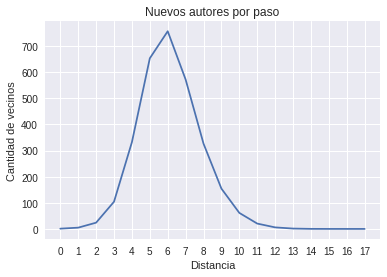

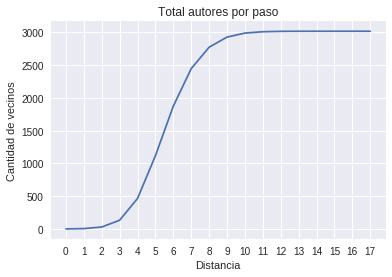

In [67]:
iterations = 2000
longest_path = max([max(node_distances.values()) for node_distances in all_distances.values()]) + 1
results = np.zeros((iterations, longest_path), dtype=int)

for iteration in range(iterations):
    diferencial = authors_by_distance(componente_conexa_gigante)
    
    for distance, quantity in diferencial.items():
        results[iteration, distance] = quantity

diferencial_means = results.mean(axis=0)
incremental_means = []

previous_quantity = 0
for quantity in diferencial_means:
    incremental_means.append(quantity + previous_quantity)
    previous_quantity = quantity + previous_quantity

def plot(y, title):
    sns.plt.figure()
    sns.plt.title(title)
    sns.plt.ylabel("Cantidad de vecinos")
    sns.plt.xlabel("Distancia")
    sns.plt.xticks(range(longest_path+1))
    sns.plt.plot(range(longest_path),y)

plot(diferencial_means, "Nuevos autores por paso")
plot(incremental_means, "Total autores por paso")

In [74]:
max_diferencial_index = np.argmax(diferencial_means)
print("A los {0} nodos de distancia se encuentra la mayor cantidad de vecinos agregados: {1}" \
     .format(max_diferencial_index, diferencial_means[max_diferencial_index]))

A los 6 nodos de distancia se encuentra la mayor cantidad de vecinos agregados: 756.8075


Para este punto tomamos un nodo al azar de la mayor componente conexa y calculamos cuantos nodos se iban agregando mientras nos alejabamos de a un paso, y cuantos vecinos en total en cada paso dispone el nodo elegido.

Este experimento lo realizamos una gran cantidad de iteraciones y graficamos el promedio de todos los valores para ganar mayor robustez en el resultado.

Como podemos observar, claramente es a los 6 grados de distancia cuando se agrega la mayor cantidad de vecinos. A partir de allí, decrementa la cantidad de vecinos que se suman.

5)

In [76]:
clustering = nx.average_clustering(componente_conexa_gigante)
avg_shortest_path_length = nx.average_shortest_path_length(componente_conexa_gigante)

degrees_seq = list(dict(componente_conexa_gigante.degree()).values())
# Hago un grafo aleatorio con la distribución de grados
GR = nx.configuration_model(degrees_seq, create_using=nx.Graph())


#Me quedo con la componente conexa más grande del grafo aleatoreo
componente_conexa_gigante_GR = calcular_componente_conexa_gigante(GR)

random_G = GR.subgraph(componente_conexa_gigante_GR)
print(nx.Graph(random_G))

clustering_random = nx.average_clustering(random_G)
avg_shortest_path_length_random = nx.average_shortest_path_length(random_G)

print('Grafo componente gigante:')
print('\tClustering: {0}'.format(clustering))
print('\tCamino minimo medio: {0}'.format(avg_shortest_path_length))

print(u'Grafo aleatorio con la misma distribución:')
print('\tClustering: {0}'.format(clustering_random))
print('\tCamino minimo medio: {0}'.format(avg_shortest_path_length_random))

configuration_model 3018 nodes 7250 edges
Grafo componente gigante:
	Clustering: 0.4840014369969915
	Camino minimo medio: 6.131037221593651
Grafo aleatorio con la misma distribución:
	Clustering: 0.0028432720519848886
	Camino minimo medio: 4.747559186395465


6)

In [79]:
def analizar_centralidad(grafo, repeticiones, degree):
    completo = grafo.copy()
    
    for i in range(repeticiones):
        print("iteracion: ", i)
        componente_gigante = calcular_componente_conexa_gigante(completo)
        analizar_grafo(componente_gigante)
        
        if degree :
            degree_centralty = nx.degree_centrality(componente_gigante)
        else :
            betweenness_centralty = nx.betweenness_centrality(componente_gigante)
        
        if degree :
            important_node = max(degree_centralty.items(), key=operator.itemgetter(1))[0]
        else :
            important_node = max(betweenness_centralty.items(), key=operator.itemgetter(1))[0]
        
        completo.remove_node(important_node)
        print()

In [80]:
analizar_centralidad(G,500,True)

iteracion:  0
Cantidad de nodos: 3018
Cantidad de aristas: 7269

iteracion:  1
Cantidad de nodos: 3013
Cantidad de aristas: 7215

iteracion:  2
Cantidad de nodos: 3012
Cantidad de aristas: 7174

iteracion:  3
Cantidad de nodos: 3007
Cantidad de aristas: 7137

iteracion:  4
Cantidad de nodos: 3006
Cantidad de aristas: 7102

iteracion:  5
Cantidad de nodos: 3005
Cantidad de aristas: 7069

iteracion:  6
Cantidad de nodos: 2997
Cantidad de aristas: 7033

iteracion:  7
Cantidad de nodos: 2995
Cantidad de aristas: 7004

iteracion:  8
Cantidad de nodos: 2994
Cantidad de aristas: 6976

iteracion:  9
Cantidad de nodos: 2992
Cantidad de aristas: 6949

iteracion:  10
Cantidad de nodos: 2990
Cantidad de aristas: 6923

iteracion:  11
Cantidad de nodos: 2987
Cantidad de aristas: 6897

iteracion:  12
Cantidad de nodos: 2984
Cantidad de aristas: 6871

iteracion:  13
Cantidad de nodos: 2983
Cantidad de aristas: 6846

iteracion:  14
Cantidad de nodos: 2982
Cantidad de aristas: 6821

iteracion:  15
Canti


iteracion:  227
Cantidad de nodos: 2125
Cantidad de aristas: 3315

iteracion:  228
Cantidad de nodos: 2124
Cantidad de aristas: 3307

iteracion:  229
Cantidad de nodos: 2122
Cantidad de aristas: 3299

iteracion:  230
Cantidad de nodos: 2108
Cantidad de aristas: 3279

iteracion:  231
Cantidad de nodos: 2107
Cantidad de aristas: 3271

iteracion:  232
Cantidad de nodos: 2105
Cantidad de aristas: 3263

iteracion:  233
Cantidad de nodos: 2102
Cantidad de aristas: 3255

iteracion:  234
Cantidad de nodos: 2097
Cantidad de aristas: 3243

iteracion:  235
Cantidad de nodos: 2094
Cantidad de aristas: 3234

iteracion:  236
Cantidad de nodos: 2093
Cantidad de aristas: 3226

iteracion:  237
Cantidad de nodos: 2090
Cantidad de aristas: 3217

iteracion:  238
Cantidad de nodos: 2088
Cantidad de aristas: 3209

iteracion:  239
Cantidad de nodos: 2083
Cantidad de aristas: 3197

iteracion:  240
Cantidad de nodos: 2017
Cantidad de aristas: 3086

iteracion:  241
Cantidad de nodos: 2016
Cantidad de aristas: 

Cantidad de aristas: 66

iteracion:  418
Cantidad de nodos: 50
Cantidad de aristas: 58

iteracion:  419
Cantidad de nodos: 47
Cantidad de aristas: 55

iteracion:  420
Cantidad de nodos: 47
Cantidad de aristas: 50

iteracion:  421
Cantidad de nodos: 47
Cantidad de aristas: 74

iteracion:  422
Cantidad de nodos: 46
Cantidad de aristas: 53

iteracion:  423
Cantidad de nodos: 46
Cantidad de aristas: 58

iteracion:  424
Cantidad de nodos: 45
Cantidad de aristas: 60

iteracion:  425
Cantidad de nodos: 44
Cantidad de aristas: 50

iteracion:  426
Cantidad de nodos: 43
Cantidad de aristas: 49

iteracion:  427
Cantidad de nodos: 42
Cantidad de aristas: 56

iteracion:  428
Cantidad de nodos: 42
Cantidad de aristas: 53

iteracion:  429
Cantidad de nodos: 41
Cantidad de aristas: 50

iteracion:  430
Cantidad de nodos: 40
Cantidad de aristas: 51

iteracion:  431
Cantidad de nodos: 39
Cantidad de aristas: 43

iteracion:  432
Cantidad de nodos: 39
Cantidad de aristas: 49

iteracion:  433
Cantidad de no

Hablar del chamuyo de que pensabamos que en pocos pasos se iban a separar las comunidades y nos dió que alrededor del 10% DE LOS AUTORES MAS IMPORTANTES HAY QUE BORRAR PARA ROMPERLO

hacer algún gráfico loco